#Ensemble Model learning - Making Predictions from FT models using majority voting

by Kaushik Srivatsan - 3rd Year, CDS - kaushik.s-25@scds.saiuniversity.edu.in


## Importing Packages and Modules


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
print(tf.__version__)

from tensorflow import keras
tf.random.set_seed(42)

import numpy as np
np.random.seed(42)

import matplotlib.pyplot as plt
%matplotlib inline

import glob
import PIL
from PIL import Image

2.15.0


## Loading the preprocessed Dataset and Models

In [3]:
# load numpy array from npy file
from numpy import load

X_train_std = load('/content/drive/MyDrive/Models/X_train_std_model3.npy')
X_test_std = load('/content/drive/MyDrive/Models/X_test_std_model3.npy')

y_train = load('/content/drive/MyDrive/Models/y_train_model3.npy')
y_test = load('/content/drive/MyDrive/Models/y_test_model3.npy')

In [4]:
print("X_train_std_shape: {}".format(X_train_std.shape))
print("X_test_std_shape: {}".format(X_test_std.shape))

X_train_std_shape: (373, 299, 299, 3)
X_test_std_shape: (125, 299, 299, 3)


In [5]:
Model1_FT = keras.models.load_model('/content/drive/MyDrive/Models/model1_FT.h5')
Model2_FT = keras.models.load_model('/content/drive/MyDrive/Models/model2_FT.h5')




In [6]:
#Importing layers and stochastic depth to mitigate the export issue of keras with respect to the convnext model
from keras import layers

class StochasticDepth(layers.Layer):
    """Stochastic Depth module.

    It performs batch-wise dropping rather than sample-wise. In libraries like
    `timm`, it's similar to `DropPath` layers that drops residual paths
    sample-wise.

    References:
      - https://github.com/rwightman/pytorch-image-models

    Args:
      drop_path_rate (float): Probability of dropping paths. Should be within
        [0, 1].

    Returns:
      Tensor either with the residual path dropped or kept.
    """

    def __init__(self, drop_path_rate, **kwargs):
        super().__init__(**kwargs)
        self.drop_path_rate = drop_path_rate

    def call(self, x, training=None):
        if training:
            keep_prob = 1 - self.drop_path_rate
            shape = (tf.shape(x)[0],) + (1,) * (len(tf.shape(x)) - 1)
            random_tensor = keep_prob + tf.random.uniform(shape, 0, 1)
            random_tensor = tf.floor(random_tensor)
            return (x / keep_prob) * random_tensor
        return x

    def get_config(self):
        config = super().get_config()
        config.update({"drop_path_rate": self.drop_path_rate})
        return config

class LayerScale(layers.Layer):
    """Layer scale module.

    References:
      - https://arxiv.org/abs/2103.17239

    Args:
      init_values (float): Initial value for layer scale. Should be within
        [0, 1].
      projection_dim (int): Projection dimensionality.

    Returns:
      Tensor multiplied to the scale.
    """

    def __init__(self, init_values, projection_dim, **kwargs):
        super().__init__(**kwargs)
        self.init_values = init_values
        self.projection_dim = projection_dim

    def build(self, input_shape):
        self.gamma = tf.Variable(
            self.init_values * tf.ones((self.projection_dim,))
        )

    def call(self, x):
        return x * self.gamma

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "init_values": self.init_values,
                "projection_dim": self.projection_dim,
            }
        )
        return config


Model3_FT = keras.models.load_model('/content/drive/MyDrive/Models/model3_FT.h5', compile=False, custom_objects={ "LayerScale": LayerScale, "StochasticDepth": StochasticDepth})

## Evaluating FT Model 1

Generating Confusion Matrix, Precision, Recall and F1-Score

4/4 [==============================] - 17s 2s/step


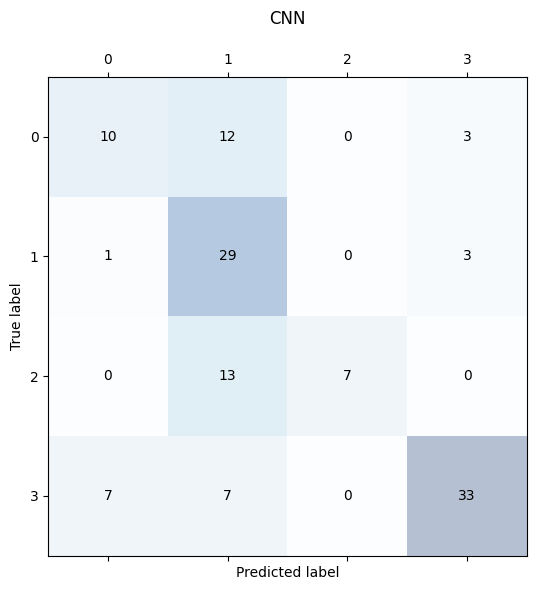

In [7]:
y_proba1 = Model1_FT.predict(X_test_std)
y_predict1 = np.argmax(y_proba1, axis=-1)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true = y_test, y_pred = y_predict1)

fig, ax = plt.subplots(figsize=(6, 6))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i, s=cm[i, j], va='center', ha='center')

ax.title.set_text('CNN\n')
plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
plt.savefig("ConfusionMatrix.png", dpi=300, format='png', pad_inches=0.3)
plt.show()

In [8]:
from sklearn.metrics import precision_score, recall_score, f1_score

pScore = precision_score(y_true= y_test, y_pred = y_predict1, average = 'weighted')
print("Precision: ", pScore)

rScore = recall_score(y_true= y_test, y_pred = y_predict1, average = 'weighted')
print("Recall: ", rScore)

fScore = f1_score(y_true= y_test, y_pred = y_predict1, average = 'weighted')
print("F1-score: ", fScore)


Precision:  0.7147731539862686
Recall:  0.632
F1-score:  0.6274379753330768


## Evaluating FT Model 2

Generating Confusion Matrix, Precision, Recall and F1-Score

4/4 [==============================] - 25s 4s/step


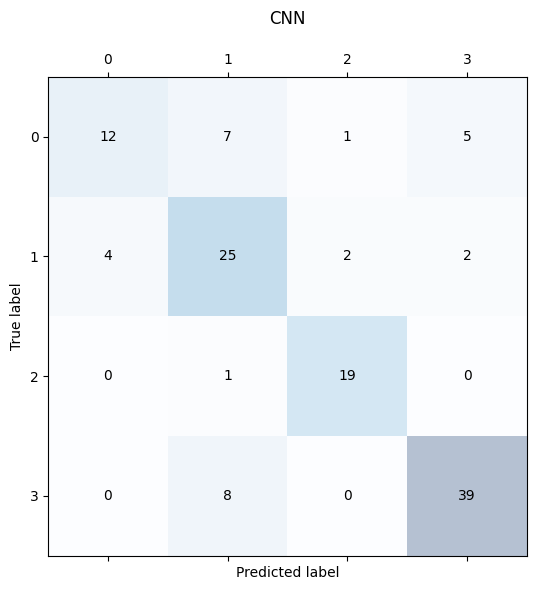

In [9]:
y_proba2 = Model2_FT.predict(X_test_std)
y_predict2 = np.argmax(y_proba2, axis=-1)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true = y_test, y_pred = y_predict2)

fig, ax = plt.subplots(figsize=(6, 6))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i, s=cm[i, j], va='center', ha='center')

ax.title.set_text('CNN\n')
plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
plt.savefig("ConfusionMatrix.png", dpi=300, format='png', pad_inches=0.3)
plt.show()

In [10]:
from sklearn.metrics import precision_score, recall_score, f1_score

pScore = precision_score(y_true= y_test, y_pred = y_predict2, average = 'weighted')
print("Precision: ", pScore)

rScore = recall_score(y_true= y_test, y_pred = y_predict2, average = 'weighted')
print("Recall: ", rScore)

fScore = f1_score(y_true= y_test, y_pred = y_predict2, average = 'weighted')
print("F1-score: ", fScore)

Precision:  0.7679400366335679
Recall:  0.76
F1-score:  0.7555682925816679


## Evaluating FT Model 3

Generating Confusion Matrix, Precision, Recall and F1-Score

4/4 [==============================] - 1s 269ms/step


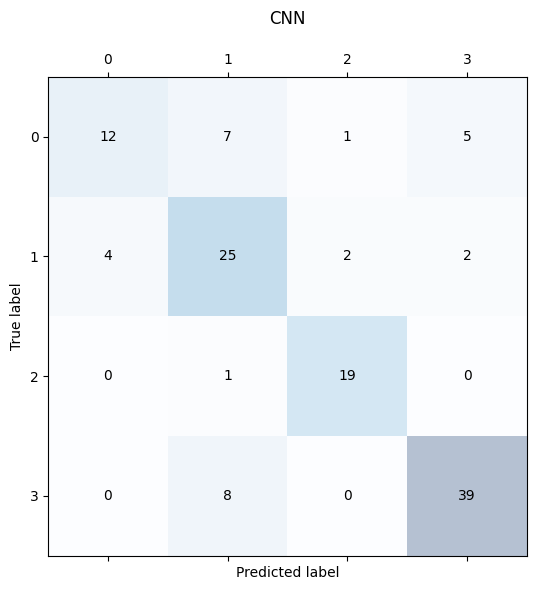

In [11]:
y_proba2 = Model2_FT.predict(X_test_std)
y_predict2 = np.argmax(y_proba2, axis=-1)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true = y_test, y_pred = y_predict2)

fig, ax = plt.subplots(figsize=(6, 6))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i, s=cm[i, j], va='center', ha='center')

ax.title.set_text('CNN\n')
plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
plt.savefig("ConfusionMatrix.png", dpi=300, format='png', pad_inches=0.3)
plt.show()

In [12]:
from sklearn.metrics import precision_score, recall_score, f1_score

pScore = precision_score(y_true= y_test, y_pred = y_predict2, average = 'weighted')
print("Precision: ", pScore)

rScore = recall_score(y_true= y_test, y_pred = y_predict2, average = 'weighted')
print("Recall: ", rScore)

fScore = f1_score(y_true= y_test, y_pred = y_predict2, average = 'weighted')
print("F1-score: ", fScore)

Precision:  0.7679400366335679
Recall:  0.76
F1-score:  0.7555682925816679


## Ensemble Predict Function

Writing a Functionn that makes predictions based on the existing FT models based on majority voting by argmax and bincount

In [13]:

def Ensemble_Predict(img):
    class_names = ['andesite', 'basalt', 'coal', 'granite']
    predictions = []
    test = np.expand_dims(img, axis=0)

    pred1 = np.argmax(Model1_FT.predict(test), axis=-1)
    pred2 = np.argmax(Model2_FT.predict(test), axis=-1)
    pred3 = np.argmax(Model3_FT.predict(test), axis=-1)

    predictions.extend(pred1)
    predictions.extend(pred2)
    predictions.extend(pred3)
    ensemble_pred = np.bincount(predictions).argmax()
    predicted_class = class_names[ensemble_pred]
    return predicted_class




In [14]:
#Testing the function using an randomly imported image from Test dataset
import random
test_img = random.choice(X_test_std)
pred = Ensemble_Predict(test_img)
print("Class of the Image is predicted to be:",pred)


1/1 [==============================] - 5s 5s/step
Class of the Image is predicted to be: granite


In [15]:
# Testing the function using an randoly imported image from the entire Dataset
import random
imgFiles = glob.glob("/content/drive/MyDrive/DL_Main/DL_Project/Hutton_Rock/*/*.jpg")
fName = random.choice(imgFiles)
  # Prepare the dataset and populate X and y
X_i = Image.open(fName)
X_i = X_i.resize((299,299))
X_i = (np.array(X_i).astype(np.float32) /127.5) - 1

if X_i.shape == (299, 299, 3):
    label = fName.split("/")
    y_i = label[-2]
    pred_img = Ensemble_Predict(X_i)
    print("Class of the Image is predicted to be:",pred_img)

## Evaluating the Performance of Ensemble Learning

Testing the Performance using Confusion Matrix, Precision, Recall and F1-Scores

In [16]:

ensemble_predictions = []
for img in X_test_std:
    prediction = Ensemble_Predict(img)
    ensemble_predictions.append(prediction)

1/1 [==============================] - 0s 80ms/step


In [17]:
print(ensemble_predictions)
class_mapping = {
    'andesite':0,
    'basalt':1,
    'coal' : 2,
    'granite' :3
}
ensemble_predictions = [class_mapping[pred] for pred in ensemble_predictions]
print(ensemble_predictions)

['basalt', 'coal', 'basalt', 'basalt', 'basalt', 'granite', 'granite', 'basalt', 'basalt', 'basalt', 'granite', 'basalt', 'granite', 'basalt', 'basalt', 'basalt', 'basalt', 'granite', 'basalt', 'basalt', 'basalt', 'basalt', 'andesite', 'coal', 'basalt', 'granite', 'andesite', 'coal', 'andesite', 'granite', 'granite', 'basalt', 'basalt', 'andesite', 'basalt', 'andesite', 'basalt', 'granite', 'basalt', 'basalt', 'granite', 'andesite', 'coal', 'andesite', 'basalt', 'andesite', 'basalt', 'granite', 'basalt', 'granite', 'basalt', 'basalt', 'granite', 'andesite', 'andesite', 'basalt', 'basalt', 'basalt', 'coal', 'coal', 'andesite', 'granite', 'basalt', 'granite', 'granite', 'granite', 'basalt', 'basalt', 'basalt', 'basalt', 'coal', 'granite', 'basalt', 'granite', 'andesite', 'basalt', 'granite', 'basalt', 'basalt', 'basalt', 'basalt', 'basalt', 'granite', 'basalt', 'basalt', 'andesite', 'granite', 'andesite', 'basalt', 'andesite', 'basalt', 'basalt', 'basalt', 'granite', 'basalt', 'basalt', 

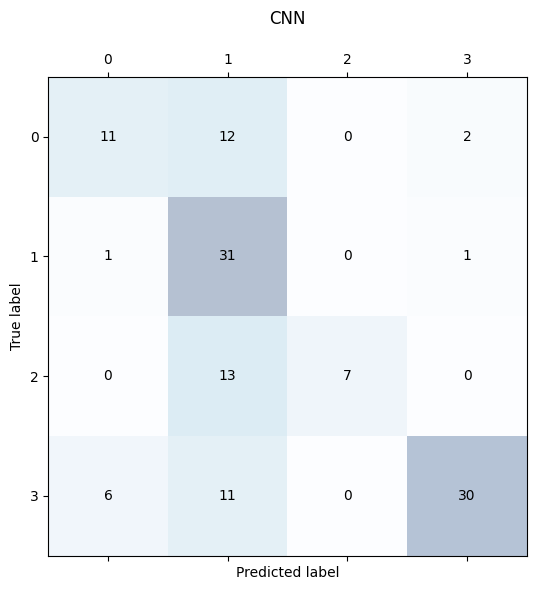

In [18]:

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true = y_test, y_pred = ensemble_predictions)

fig, ax = plt.subplots(figsize=(6, 6))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i, s=cm[i, j], va='center', ha='center')

ax.title.set_text('CNN\n')
plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
plt.savefig("ConfusionMatrix.png", dpi=300, format='png', pad_inches=0.3)
plt.show()

In [19]:
from sklearn.metrics import precision_score, recall_score, f1_score

pScore = precision_score(y_true= y_test, y_pred = ensemble_predictions, average = 'weighted')
print("Precision: ", pScore)

rScore = recall_score(y_true= y_test, y_pred = ensemble_predictions, average = 'weighted')
print("Recall: ", rScore)

fScore = f1_score(y_true= y_test, y_pred = ensemble_predictions, average = 'weighted')
print("F1-score: ", fScore)

Precision:  0.7461896577717473
Recall:  0.632
F1-score:  0.6309685443583117
